In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_data = pd.read_csv("/kaggle/input/cs-480-2024-spring/data/train.csv")
test_data = pd.read_csv("/kaggle/input/cs-480-2024-spring/data/test.csv")

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

X_train = train_data.iloc[:, 1:164]
y_train = train_data.iloc[:, 164:]
X_test = test_data.iloc[:, 1:164]

def normalize_image(path):
    image = load_img(path, target_size=(128, 128))
    image = img_to_array(image)
    image = image / 255.0
    return image

train_images = np.array([normalize_image(f'/kaggle/input/cs-480-2024-spring/data/train_images/{img_id}.jpeg') for img_id in train_data['id']])
test_images = np.array([normalize_image(f'/kaggle/input/cs-480-2024-spring/data/test_images/{img_id}.jpeg') for img_id in test_data['id']])

2024-08-12 14:19:48.481010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 14:19:48.481151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 14:19:48.645843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)

labels = Input(shape=(163,))
y = Dense(64, activation='relu')(labels)
y = Dense(128, activation='relu')(y)

combined = Concatenate()([x, y])
z = Dense(128, activation='relu')(combined)
z = Dense(y_train.shape[1], activation='linear')(z)

model = Model(inputs=[base_model.input, labels], outputs=z)
model.compile(optimizer='adam', loss='mse')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Epoch 1/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1155s 1s/step - loss: 0.8897 - val_loss: 0.8488
Epoch 2/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1105s 1s/step - loss: 0.8167 - val_loss: 0.8467
Epoch 3/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1098s 1s/step - loss: 0.8213 - val_loss: 0.8391
Epoch 4/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1101s 1s/step - loss: 0.8088 - val_loss: 0.8357
Epoch 5/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1097s 1s/step - loss: 0.7959 - val_loss: 0.8374
Epoch 6/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1092s 1s/step - loss: 0.8001 - val_loss: 0.8351
Epoch 7/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1094s 1s/step - loss: 0.7920 - val_loss: 0.8306
Epoch 8/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1109s 1s/step - loss: 0.7848 - val_loss: 0.8338
Epoch 9/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1102s 1s/step - loss: 0.7921 - val_loss: 0.8310
Epoch 10/10
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1096s 1s/step - loss: 0.7781 - val_loss: 0.8330


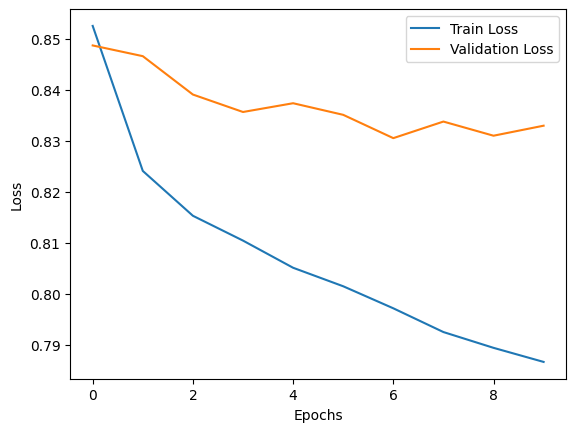

In [6]:
import matplotlib.pyplot as plt

history = model.fit(
    [train_images, X_train], y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
predictions = model.predict([test_images, X_test])

rescaled = scaler.inverse_transform(predictions)

submission = pd.DataFrame(rescaled, columns=['X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])
submission.insert(0, 'id', test_data['id'])
submission.to_csv('submission.csv', index=False)

200/200 ━━━━━━━━━━━━━━━━━━━━ 164s 810ms/step
